In [70]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from biodata.delimited import DelimitedReader, DelimitedWriter
import numpy as np
import pyBigWig
from collections import defaultdict, Counter
import seaborn as sns
import itertools
from biodatatools.utils.common import json_dump
from matplotlib.font_manager import FontProperties
from pathlib import Path
import pybedtools
import biodataplot.metaplot as bpm
from biodata.bigwig import BigWigIReader
from biodata.bed import BEDXReader
from genomictools import GenomicCollection
import sys

In [3]:
matplotlib.font_manager.fontManager.addfont(f"{Path.cwd().parent}/font/Arial.ttf")
matplotlib.rcParams["font.family"] = "Arial"
bfontsize = 12
sfontsize = 9

In [60]:
sys.path.append(f"{Path.cwd().parent}")
import utils

In [50]:
PROJECT_DIR_d = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/PROcap/"
PROJECT_DIR_r = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/resources/"
PROJECT_DIR_o = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/"

# Data preparation

In [5]:
s = "HEK293T"
factor = "ZNF143"
ks = ["pl", "mn"]
ts = ["minTSS", "maxTSS"]
ps = ["divergent", "unidirectional"]
ds = ["distal", "proximal"]
gs = [f"{p}_{d}" for p, d in itertools.product(ps, ds)]
labels = ["Up", "Unchanged", "Down"]

In [6]:
df_metadata = pd.DataFrame({"Condition": ["U", "U", "T", "T"]}, columns=["Condition"], index=["U1", "U2", "T1", "T2"])
outputfile = f"{PROJECT_DIR_o}DE/{s}_metadata.txt"
df_metadata.to_csv(outputfile, sep="\t")

In [7]:
reps = list(df_metadata.index)
bws = {}
for r in reps:
	bws[r] = [f"{PROJECT_DIR_d}Alignments/{factor}_{r}_5{k}.bw" for k in ks]

In [8]:
results = []
index = []
for g in gs:
	inputfile = f"{PROJECT_DIR_d}bed_plot/{s}_{g}.bed"
	df = pd.read_table(inputfile, header=None)
	for _, row in df.iterrows():
		chrom, start, end = row[:3]
		sign = row[7]
		for t in ts:
			index.append("_".join([chrom, str(start), str(end), t, g]))
			row = []
			for r in bws:
				pl, mn = bws[r]
				bw1 = pyBigWig.open(pl)
				bw2 = pyBigWig.open(mn)
				reads1 = 0
				reads2 = 0
				
				if bw1.intervals(chrom, start, end) != None:
					for start2, end2, score in bw1.intervals(chrom, start, end):
						l = min(end, end2) - max(start, start2)
						reads1 += abs(score) * l
				if bw2.intervals(chrom, start, end) != None:
					for start2, end2, score in bw2.intervals(chrom, start, end):
						l = min(end, end2) - max(start, start2)
						reads2 += abs(score) * l
			
				if t == "maxTSS":
					row.append(reads1 if sign == "+" else reads2)
				else:
					row.append(reads2 if sign == "+" else reads1)
			results.append(row)
			
df_counts = pd.DataFrame(results, columns=reps, index=index)
outputfile = f"{PROJECT_DIR_o}DE/{s}_counts.txt"
df_counts.to_csv(outputfile, sep="\t")

# Run DESeq2

In [9]:
# Run DESeq2 in "2-2.DESeq2.ipynb" (also see explanation of NA values there)

inputfile = f"{PROJECT_DIR_o}DE/{s}_DEseq2_R.txt"
res = pd.read_table(inputfile)
res = res.dropna()
res.head(2)

,baseMean,log2FoldChange,lfcSE,pvalue,padj
chr1_916612_917113_minTSS_divergent_distal,33.052534,0.013604,0.103061,0.321863,0.999883
chr1_916612_917113_maxTSS_divergent_distal,31.460278,0.013133,0.105109,0.351065,0.999883


In [10]:
padj_cutoff = 0.05
lfc_cutoff = np.log2(1.5)
conditions = [
	(res["padj"] < padj_cutoff) & (res["log2FoldChange"] > lfc_cutoff),
	(res["padj"] < padj_cutoff) & (res["log2FoldChange"] < -lfc_cutoff),
]
choices = ["Up", "Down"]
res["Label"] = np.select(conditions, choices, default="Unchanged")

# Volcano plot

In [117]:
def volcano_plot(res, d, t, loc, ax, ylim, yticks, ylabel=True):
	res2 = res[res.index.str.contains(d) & res.index.str.contains(t)].copy()
	res2["-log10padj"] = -np.log10(res2["padj"])
	g = sns.scatterplot(data=res2, x="log2FoldChange", y="-log10padj", 
						hue="Label", hue_order=labels,
						palette=["#FFD700","#d9d9d9","#b3de69"], 
						alpha=0.7, s=30, ax=ax)
	g.spines[["right", "top"]].set_visible(False)
	g.set_title(t, fontsize=bfontsize, pad=5)
	
	g.set_ylim(ylim)
	g.set_yticks(yticks)
	if ylabel:
		g.set_ylabel(r"-log$_{10}$(q-value)", fontsize=bfontsize)
	else:
		g.set_ylabel("")
		g.set_yticklabels([])

	g.set_xlim([-8, 8])
	g.set_xlabel(r"log$_2$(T/UT)", fontsize=bfontsize)
	
	g.tick_params(labelsize=sfontsize)
	
	legend = g.legend(handletextpad=0, labelspacing=0.3)
	for label in labels:
		legend.get_texts()[labels.index(label)].set_text(label+" (n=" + str(len(res2[res2["Label"]==label])) + ")")
		legend.get_texts()[labels.index(label)].set_fontsize(sfontsize)

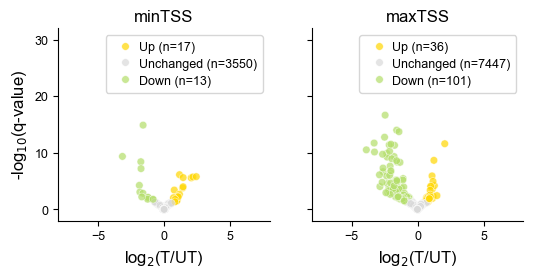

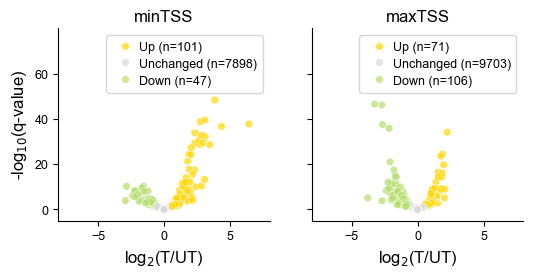

In [119]:
for d in ds:
	fig, ax = plt.subplots(1,2,figsize=(6,2.5))
	if d == "distal":
		ylim = [-2,32]
		yticks = [0,10,20,30]
		outputfile = f"{PROJECT_DIR_o}figures/SuppFig8a.png"
	else:
		ylim = [-5,80]
		yticks = [0,20,40,60]
		outputfile = f"{PROJECT_DIR_o}figures/SuppFig8b.png"
		
	for t in ts:
		col = ts.index(t)
		ylabel = True if col == 0 else False
		volcano_plot(res, d, t, loc, ax[col], ylim, yticks, ylabel)
	
	plt.savefig(outputfile, bbox_inches="tight", dpi=300, transparent=True)

In [13]:
# Get labels for each element

DE_labels = defaultdict(dict)
for t, g in itertools.product(ts, gs):
	inputfile = f"{PROJECT_DIR_d}bed_plot/{s}_{g}.bed"
	with DelimitedReader(inputfile) as dr:
		for cols in dr:
			chrom, start, end = cols[:3]
			e = "_".join([chrom, start, end, t, g])
			if e in res.index:
				DE_labels[t]["_".join([chrom, start, end])] = res.loc[e]["Label"]

In [14]:
json_dump(f"{PROJECT_DIR_o}labels/{s}_{factor}_DE.json", DE_labels)

# Sanity check

In [ ]:
# Verify whether the up- or down-regulated regions (PRO-cap) show ZNF143 ChIP-seq binding before treatment and whether these regions display reduced ZNF143 signals after treatment.
# Regions with unchanged PRO-cap signals are expected to show low ZNF143 binding before and after treatment.

In [84]:
bws = {"ZNF143_U": f"{PROJECT_DIR_r}other/GSE266489/GSE266489_antiZNF143-control_merged_normalized.bigWig",
	   "ZNF143_T": f"{PROJECT_DIR_r}other/GSE266489/GSE266489_antiZNF143-dTAG_merged_normalized.bigWig"
	  }
ms = list(bws.keys())

In [64]:
e_labels = defaultdict(list)
for tss in DE_labels:
	for e in DE_labels[tss]:
		e_labels[e].append(DE_labels[tss][e])

In [65]:
e_labels2 = {}
for e in e_labels:
	if "Up" in e_labels[e] and "Down" in e_labels[e]:
		continue
	if "Up" in e_labels[e]:
		e_labels2[e] = "Up"
	elif "Down" in e_labels[e]:
		e_labels2[e] = "Down"
	else:
		e_labels2[e] = "Unchanged"

In [71]:
for label in labels:
	outputfile = f"{PROJECT_DIR_o}temp/{s}_{label}.bed"
	with DelimitedWriter(outputfile) as dw:
		for e in e_labels2:
			if e_labels2[e] == label:
				dw.write(e.split("_"))
	pybedtools.BedTool(outputfile).sort().saveas(outputfile)

In [88]:
use_strand = False
df_features = {}
sort_dict = {}
for m, label in itertools.product(bws, labels):
	bed = f"{PROJECT_DIR_o}temp/{s}_{label}.bed"
	all_regions = BEDXReader.read_all(GenomicCollection, bed)
	index = [f"{r.chrom}_{r.chromStart}_{r.chromEnd}" for r in all_regions]
	df_features[(label,m)] = pd.DataFrame(bpm.generate_signal_profile(all_regions, BigWigIReader(bws[m]), fixed_size=1001, use_strand=use_strand), index=index)
	if m == "ZNF143_U":
		row_sums = df_features[(label,m)].sum(axis=1).to_dict()
		sort_dict.update({str(key): value for key, value in row_sums.items()})
sort_file = f"{PROJECT_DIR_o}labels/{s}_{m}_sum.json"	
json_dump(sort_file, sort_dict)

In [ ]:
fig, axes = plt.subplots(len(ms), len(labels), figsize=(6, 4))

labelpad = 2
y_align = -0.25
wspace = 0.3
hspace = 0.3
hue_order = ["Untreated", "Treated"]
palette = ["#d9d9d9", "#313695"]
yticks = [0,2,4]
cmap = "viridis"
test = False

for label, m in df_features:
	col = labels.index(label)
	row = list(bws).index(m)
	ax = axes[row, col]
	
	cbar = False
	cbar_ax = None		
	utils.generate_feature_heatmap(df_features[(label, m)], yticks, cmap, cbar, cbar_ax, cbar_kws, ax, sort_file, test)
	
	if row == 0:
		ax.set_title(label, fontsize=bfontsize)

	ax.set_xticks([0,500,1000])
	if row == 1:
		ax.set_xlabel("Distance (kb)", fontsize=bfontsize)
		ax.set_xticklabels([-0.5, 0, 0.5])

	if col == 0:
		factor, treatment = m.split("_")
		ylabel = f"{factor} (UT)" if treatment == "U" else f"{factor} (T)"
		ax.set_ylabel(ylabel, fontsize=bfontsize)
		ax.get_yaxis().set_label_coords(y_align/3, 0.5)
	else:
		ax.set_ylabel("")

	if row == 0 and col == 2:
		cbar_ax = fig.add_axes([0.95, 0.4, 0.03, 0.3])
		cbar = plt.colorbar(ax.collections[0], cax=cbar_ax)
		cbar.set_ticks(yticks)
		cbar.ax.tick_params(labelsize=sfontsize)
		cbar.set_label("ChIP-seq", fontsize=bfontsize)
		
outputfile = f"{PROJECT_DIR_o}figures/SuppFig8c.png"
plt.savefig(outputfile, bbox_inches="tight", dpi=300, transparent=True) 